<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# create Agent

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Model
from keras.layers import Input, Dense
import matplotlib.pyplot as plt
from keras.models import load_model

model = load_model('/content/drive/My Drive/CNN_stock_model/Rikcy_net.h5')

class Agent:
  #初始化神經網路大腦
  def __init__(self,model):
    self.model = model
  #選擇動作
  def choose_action(self,features):
    return self.model.predict(features)

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
Ricky = Agent(model)

# 準備features(15X15X1的圖片)

In [0]:
#!pip install finta
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
SID = '^TWII'
df = web.DataReader(SID,'yahoo',start="1980-01-01")#,end="2019-09-10")
df = df.iloc[:,:5]

In [0]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

In [6]:
df['RSI'] = TA.RSI(ohlcv)
df['Williams %R'] = TA.WILLIAMS(ohlcv)
df['SMA'] = TA.SMA(ohlcv)
df['EMA'] = TA.EMA(ohlcv)
df['WMA'] = TA.WMA(ohlcv)
df['HMA'] = TA.HMA(ohlcv)
df['TEMA'] = TA.TEMA(ohlcv)
df['CCI'] = TA.CCI(ohlcv)
df['CMO'] = TA.CMO(ohlcv)
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
df['ROC'] = TA.ROC(ohlcv)
df['CFI'] = TA.CFI(ohlcv)
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
df['SAR'] = TA.SAR(ohlcv)

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas
/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

In [7]:
print(df.shape)

df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #取15個剛剛建立的技術指標當特徵
df = df[features]#重新定義df

print(df.shape)
df.tail()

(5458, 20)
(5375, 15)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,
2019-09-05,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767,0.384245,2.227890,3.291572e+12,19.338268,10442.728186
2019-09-06,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828,0.430984,2.421097,3.386218e+12,21.718306,10494.547614
2019-09-10,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827,0.423447,2.125399,3.452463e+12,15.981934,10550.081700
2019-09-11,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751,0.419735,2.393591,3.521049e+12,14.624074,10602.071414
2019-09-12,73.230165,-5.940344,10639.116854,10711.789354,10668.285742,10779.563770,10846.859428,117.556162,64.031319,44.595746,0.420264,4.607331,3.577165e+12,19.323585,10644.775100


In [8]:
df['triple_barrier_signal'] = 0
df.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-05,70.330664,-2.267544,10643.664920,10592.308928,10477.320247,10628.557715,10715.406837,162.484886,29.603035,40.576767,0.384245,2.227890,3.291572e+12,19.338268,10442.728186,0
2019-09-06,71.761526,-4.845474,10643.229778,10629.975072,10523.960373,10649.926758,10771.700236,148.438306,73.542822,45.547828,0.430984,2.421097,3.386218e+12,21.718306,10494.547614,0
2019-09-10,67.476249,-12.013750,10641.038562,10654.696074,10572.209570,10721.488672,10790.059251,120.498567,63.852001,44.792827,0.423447,2.125399,3.452463e+12,15.981934,10550.081700,0
2019-09-11,70.260662,-5.308822,10640.209294,10681.826781,10618.959288,10766.714746,10815.129097,113.508980,63.191856,44.459751,0.419735,2.393591,3.521049e+12,14.624074,10602.071414,0
2019-09-12,73.230165,-5.940344,10639.116854,10711.789354,10668.285742,10779.563770,10846.859428,117.556162,64.031319,44.595746,0.420264,4.607331,3.577165e+12,19.323585,10644.775100,0


# features scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler
import joblib

min_max_scaler = joblib.load('/content/drive/My Drive/CNN_stock_model/MinMax_scaler_v12.pkl')

df_minmax = min_max_scaler.transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index = df.index,
                         columns = df.columns)#轉回dataframe格式
df_minmax.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-05,0.745295,0.977325,0.960725,0.928341,0.907180,0.924040,0.931498,0.837743,0.648015,0.727340,0.594980,0.527453,0.791416,0.712954,0.894706,0.5
2019-09-06,0.761521,0.951545,0.960663,0.933321,0.913285,0.926805,0.938713,0.808756,0.867714,0.748549,0.607020,0.531773,0.814172,0.723225,0.901300,0.5
2019-09-10,0.712927,0.879862,0.960355,0.936590,0.919601,0.936066,0.941066,0.751099,0.819260,0.745327,0.605078,0.525162,0.830100,0.698469,0.908367,0.5
2019-09-11,0.744501,0.946912,0.960238,0.940177,0.925720,0.941918,0.944279,0.736675,0.815959,0.743906,0.604122,0.531158,0.846590,0.692609,0.914983,0.5
2019-09-12,0.778175,0.940597,0.960084,0.944139,0.932177,0.943581,0.948346,0.745027,0.820157,0.744487,0.604258,0.580650,0.860083,0.712890,0.920417,0.5


In [10]:
df = df_minmax.drop('triple_barrier_signal',axis=1)
print('特徵縮放完成!')
df.tail()

特徵縮放完成!


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,
2019-09-05,0.745295,0.977325,0.960725,0.928341,0.907180,0.924040,0.931498,0.837743,0.648015,0.727340,0.594980,0.527453,0.791416,0.712954,0.894706
2019-09-06,0.761521,0.951545,0.960663,0.933321,0.913285,0.926805,0.938713,0.808756,0.867714,0.748549,0.607020,0.531773,0.814172,0.723225,0.901300
2019-09-10,0.712927,0.879862,0.960355,0.936590,0.919601,0.936066,0.941066,0.751099,0.819260,0.745327,0.605078,0.525162,0.830100,0.698469,0.908367
2019-09-11,0.744501,0.946912,0.960238,0.940177,0.925720,0.941918,0.944279,0.736675,0.815959,0.743906,0.604122,0.531158,0.846590,0.692609,0.914983
2019-09-12,0.778175,0.940597,0.960084,0.944139,0.932177,0.943581,0.948346,0.745027,0.820157,0.744487,0.604258,0.580650,0.860083,0.712890,0.920417


# Xs prepare

In [11]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#待存放序列
Xs = []

'''
若資料筆數100,days=15天,f_index=85,i只會跑到84,i+days=99,features只會跑到98天.
若資料筆數100,days=15天,f_index=85+1,i會跑到85,i+days=100,features會跑到99天.
'''
for i in tqdm(range(b_index ,f_index+1 ,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
#轉換成np_array
Xs = np.array(Xs)
print('準備完成')

100%|██████████| 5361/5361 [00:06<00:00, 848.96it/s]


準備完成


In [12]:
Xs.shape

(5361, 15, 15)

# Reshape X

In [13]:
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(5361, 15, 15, 1)


# Visualization

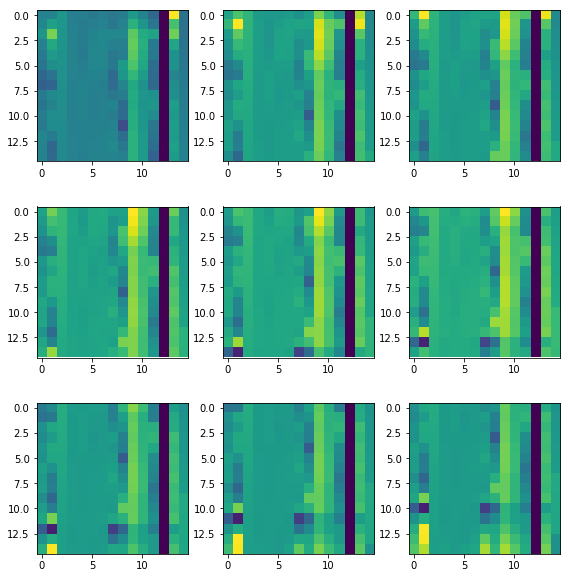

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])

# model predict

In [0]:
predict = Ricky.choose_action(Xs)
SIGNAL = [ np.argmax(i) for i in predict]

In [16]:
np.set_printoptions(suppress=True)
predict[-10:]

array([[0.00773747, 0.991553  , 0.00070946],
       [0.2508655 , 0.73357713, 0.01555732],
       [0.4239209 , 0.5415129 , 0.0345661 ],
       [0.04136856, 0.9504313 , 0.00820019],
       [0.13167632, 0.8598599 , 0.00846376],
       [0.89091575, 0.06103148, 0.04805277],
       [0.9638965 , 0.0117779 , 0.02432558],
       [0.9494689 , 0.01500463, 0.03552647],
       [0.92055744, 0.01183176, 0.06761083],
       [0.9266623 , 0.00918928, 0.06414838]], dtype=float32)

In [17]:
df = df.iloc[-len(predict):]
df['HOLD'] = predict[:,0]
df['BUY'] = predict[:,1]
df['SELL'] = predict[:,2]
df = df.iloc[:,-3:]
df = df.join(web.DataReader(SID,'yahoo',start="1980-01-01")['Close'])
df['SIGNAL'] = SIGNAL
df.tail(10)

,HOLD,BUY,SELL,Close,SIGNAL
Date,,,,,
2019-08-29,0.007737,0.991553,0.000709,10462.429688,1
2019-08-30,0.250865,0.733577,0.015557,10618.049805,1
2019-09-02,0.423921,0.541513,0.034566,10634.849609,1
2019-09-03,0.041369,0.950431,0.008200,10558.209961,1
2019-09-04,0.131676,0.859860,0.008464,10657.309570,1
2019-09-05,0.890916,0.061031,0.048053,10756.929688,0
2019-09-06,0.963897,0.011778,0.024326,10780.639648,0
2019-09-10,0.949469,0.015005,0.035526,10753.580078,0
2019-09-11,0.920557,0.011832,0.067611,10790.349609,0


# 最近一年買賣圖

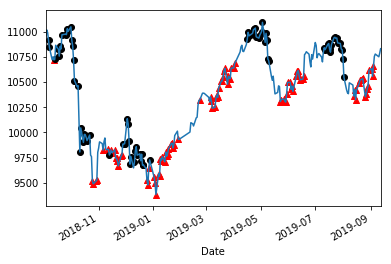

In [18]:
t = df[-250:] #最近一年
buy = t[t['SIGNAL']==1]['Close']
sell = t[t['SIGNAL']==2]['Close']
t['Close'].plot()
plt.scatter(buy.index,buy.values,color='red',marker='^')
plt.scatter(sell.index,sell.values,color='black')

# 最近40天買賣圖

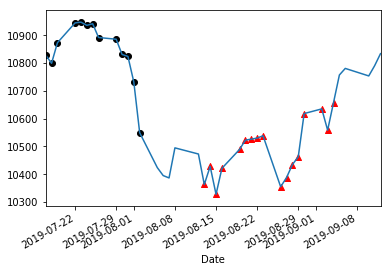

In [19]:
t = df[-40:] #最近40天
buy = t[t['SIGNAL']==1]['Close']
sell = t[t['SIGNAL']==2]['Close']
t['Close'].plot()
plt.scatter(buy.index,buy.values,color='red',marker='^')
plt.scatter(sell.index,sell.values,color='black')

# 平均 買入/賣出 價位 近40天

In [20]:
買點集合 = t[t['SIGNAL']==1]['Close']
賣點集合 = t[t['SIGNAL']==2]['Close']
print(買點集合.mean())
print(賣點集合.mean())

10485.311178768383
10844.855543870191


# 平均價差獲利

In [21]:
(賣點集合.mean()-買點集合.mean())

359.5443651018086